# LSPI approach

In [5]:
# should permanantly add this path to pythonpath instead
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book')
import matplotlib.pyplot as plt

from dataclasses import dataclass, replace
from typing import Callable, Sequence, Tuple, List
import numpy as np
from scipy.stats import norm
from rl.function_approx import \
    DNNApprox, LinearFunctionApprox, FunctionApprox, DNNSpec, AdamGradient
from random import randrange
from numpy.polynomial.laguerre import lagval

TrainingDataType = Tuple[int, float, float]

In [15]:

@dataclass(frozen=True)
class OptimalExerciseRL:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 
        
    def training_sim_data(
        self,
        num_paths: int,
        spot_price_frac: float
    ) -> Sequence[TrainingDataType]:
        ret: List[TrainingDataType] = []
        dt: float = self.expiry / self.num_steps
        spot: float = self.spot_price
        vol2: float = self.vol * self.vol

        mean2: float = spot * spot
        var: float = mean2 * spot_price_frac * spot_price_frac
        log_mean: float = np.log(mean2 / np.sqrt(var + mean2))
        log_stdev: float = np.sqrt(np.log(var / mean2 + 1))

        for i in range(num_paths):
            price: float = np.random.lognormal(log_mean, log_stdev)
            for step in range(self.num_steps):
                m: float = np.log(price) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                next_price: float = np.exp(np.random.normal(m, np.sqrt(v)))
                ret.append((step, price, next_price))
                price = next_price
        return ret
    
    def scoring_sim_data(self, num_paths: int) -> np.ndarray:
        paths: np.ndarray = np.empty([num_paths, self.num_steps + 1])
        dt: float = self.expiry / self.num_steps
        vol2: float = self.vol * self.vol
        for i in range(num_paths):
            paths[i, 0] = self.spot_price
            for step in range(self.num_steps):
                m: float = np.log(paths[i, step]) + (self.rate - vol2 / 2) * dt
                v: float = vol2 * dt
                paths[i, step + 1] = np.exp(np.random.normal(m, np.sqrt(v)))
        return paths
    
    def linear_func_approx(
        self,
        features: Sequence[Callable[[Tuple[float, float]], float]],
        reg: float
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        return LinearFunctionApprox.create(
            feature_functions=features,
            adam_gradient=self.adam_gradient(),
            regularization_coeff=reg
        )
    
    def adam_gradient(self) -> AdamGradient:
        return AdamGradient(
            learning_rate=0.1,
            decay1=0.9,
            decay2=0.999
        )
    
    def train_lspi(
        self,
        training_data: Sequence[TrainingDataType],
        init_fa: LinearFunctionApprox[Tuple[float, float]],
        training_iters: int,
        split: int
    ) -> LinearFunctionApprox[Tuple[float, float]]:
        fa: LinearFunctionApprox[Tuple[float, float]] = init_fa
        dt: float = self.expiry / self.num_steps
        gamma: float = np.exp(-self.rate * dt)
        num_features: int = len(fa.feature_functions)
        states: Sequence[Tuple[float, float]] = [(i * dt, s) for
                                                 i, s, _ in training_data]
        next_states: Sequence[Tuple[float, float]] = \
            [((i + 1) * dt, s1) for i, _, s1 in training_data]
        features: np.ndarray = fa.get_feature_values(states)
        next_features: np.ndarray = fa.get_feature_values(next_states)
        non_terminal: np.ndarray = np.array(
            [i < self.num_steps - 1 for i, _, _ in training_data]
        )
        exer: np.ndarray = np.array([self.payoff(t1, s1)
                                     for t1, s1 in next_states])
        reg_mat: np.ndarray = fa.regularization_coeff * \
            np.eye(len(fa.feature_functions))
        for i in range(training_iters):
            a_mat: np.ndarray = np.zeros([num_features, num_features])
            b_vec: np.ndarray = np.zeros(num_features)
            cont: np.ndarray = fa.evaluate(next_states)
            cont_cond: np.ndarray = non_terminal * (cont > exer)
            features_split: Sequence[np.ndarray] = \
                np.array_split(features, split)
            next_features_split: Sequence[np.ndarray] = \
                np.array_split(next_features, split, axis=0)
            cont_cond_split: Sequence[np.ndarray] = \
                np.array_split(cont_cond, split)
            exer_split: Sequence[np.ndarray] = np.array_split(exer, split)
            for i in range(split):
                a_mat += features_split[i].T.dot(
                    features_split[i] - np.diag(cont_cond_split[i]).dot(
                        next_features_split[i] * gamma
                    )
                )
                b_vec += features_split[i].T.dot(
                    (1 - cont_cond_split[i]) * exer_split[i] * gamma
                )
            a_mat /= len(training_data)
            a_mat += reg_mat
            b_vec /= len(training_data)
            wts: np.ndarray = np.linalg.solve(a_mat, b_vec)
            fa = replace(
                fa,
                weights=replace(
                    fa.weights,
                    weights=wts
                )
            )
        return fa
    
    def continuation_curve(
        self,
        func: FunctionApprox[Tuple[float, float]],
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return func.evaluate([(t, p) for p in prices])
    
    def exercise_curve(
        self,
        step: int,
        prices: Sequence[float]
    ) -> np.ndarray:
        t: float = step * self.expiry / self.num_steps
        return np.array([self.payoff(t, p) for p in prices])

    def put_option_exercise_boundary(
        self,
        func: FunctionApprox[Tuple[float, float]],
        strike: float
    ) -> Sequence[float]:
        ret: List[float] = []
        prices: np.ndarray = np.arange(0., strike + 0.1, 0.1)
        for step in range(self.num_steps):
            cp: np.ndarray = self.continuation_curve(
                func=func,
                step=step,
                prices=prices
            )
            ep: np.ndarray = self.exercise_curve(step=step, prices=prices)
            ll: Sequence[float] = [p for p, c, e in zip(prices, cp, ep)
                                   if e > c]
            ret.append(max(ll) if len(ll) > 0 else 0.)
        final: Sequence[Tuple[float, float]] = \
            [(p, self.payoff(self.expiry, p)) for p in prices]
        ret.append(max(p for p, e in final if e > 0))
        return ret
    
    def option_price(
        self,
        scoring_data: np.ndarray,
        func: FunctionApprox[Tuple[float, float]]
    ) -> float:
        num_paths: int = scoring_data.shape[0]
        prices: np.ndarray = np.zeros(num_paths)
        dt: float = self.expiry / self.num_steps

        for i, path in enumerate(scoring_data):
            step: int = 0
            while step <= self.num_steps:
                t: float = step * dt
                exercise_price: float = self.payoff(t, path[step])
                continue_price: float = func.evaluate([(t, path[step])])[0] \
                    if step < self.num_steps else 0.
                step += 1
                if exercise_price >= continue_price:
                    prices[i] = np.exp(-self.rate * t) * exercise_price
                    step = self.num_steps + 1

        return np.average(prices)
    
    
def fitted_lspi_put_option(
    obj: OptimalExerciseRL,
    strike: float,
    expiry: float,
    training_data: Sequence[TrainingDataType],
    training_iters: int,
    split: int
) -> LinearFunctionApprox[Tuple[float, float]]:

    num_laguerre: int = 3
    lspi_reg: float = 0.001

    ident: np.ndarray = np.eye(num_laguerre)
    features: List[Callable[[Tuple[float, float]], float]] = [lambda _: 1.]
    features += [(lambda t_s: np.exp(-t_s[1] / (2 * strike)) *
                  lagval(t_s[1] / strike, ident[i]))
                 for i in range(num_laguerre)]
    features += [
        lambda t_s: np.cos(-t_s[0] * np.pi / (2 * expiry)),
        lambda t_s: np.log(expiry - t_s[0]) if t_s[0] != expiry else 0.,
        lambda t_s: (t_s[0] / expiry) ** 2
    ]

    linear_approx: LinearFunctionApprox[Tuple[float, float]] = \
        obj.linear_func_approx(features=features, reg=lspi_reg)

    return obj.train_lspi(
        training_data=training_data,
        init_fa=linear_approx,
        training_iters=training_iters,
        split=split
    )


Generated Training Data
Fitted LSPI Model


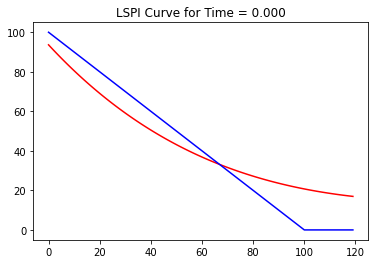

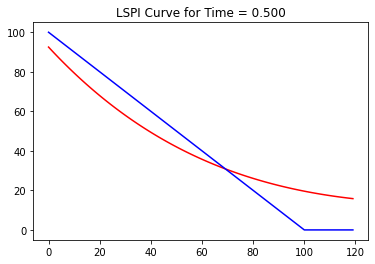

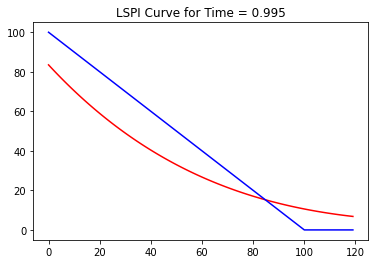

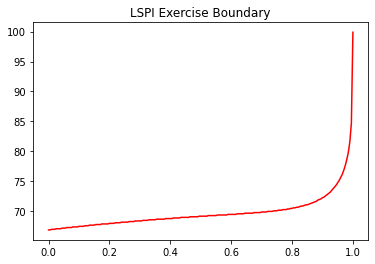

LSPI Option Price = 7.721


In [18]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    spot_price_val: float = 100.0
    strike: float = 100.0
    expiry_val: float = 1.0
    rate_val: float = 0.05
    vol_val: float = 0.25
    num_steps_val: int = 200

    dt: float = expiry_val / num_steps_val

    num_training_paths: int = 5000 #5000
    spot_price_frac_val: float = 0.0

    lspi_training_iters: int = 8 #8

    split_val: int = 1000#1000

    num_scoring_paths: int = 10000 #10000

    def payoff_func(_: float, s: float) -> float:
        return max(strike - s, 0.)

    opt_ex_rl: OptimalExerciseRL = OptimalExerciseRL(
        spot_price=spot_price_val,
        payoff=payoff_func,
        expiry=expiry_val,
        rate=rate_val,
        vol=vol_val,
        num_steps=num_steps_val
    )

    training_data: Sequence[TrainingDataType] = opt_ex_rl.training_sim_data(
        num_paths=num_training_paths,
        spot_price_frac=spot_price_frac_val
    )
    print("Generated Training Data")



    flspi: LinearFunctionApprox[Tuple[float, float]] = fitted_lspi_put_option(
        obj=opt_ex_rl,
        strike=strike,
        expiry=expiry_val,
        training_data=training_data,
        training_iters=lspi_training_iters,
        split=split_val
    )

    print("Fitted LSPI Model")

    for step in [0, int(num_steps_val / 2), num_steps_val - 1]:
        prices: np.ndarray = np.arange(120.0)
        exer_curve: np.ndarray = opt_ex_rl.exercise_curve(
            step=step,
            prices=prices
        )
        cont_curve_lspi: np.ndarray = opt_ex_rl.continuation_curve(
            func=flspi,
            step=step,
            prices=prices
        )
        plt.plot(
            prices,
            cont_curve_lspi,
            "r",
            prices,
            exer_curve,
            "b"
        )
        time: float = step * expiry_val / num_steps_val
        plt.title(f"LSPI Curve for Time = {time:.3f}")
        plt.show()

    ex_boundary_lspi: Sequence[float] = opt_ex_rl.put_option_exercise_boundary(
        func=flspi,
        strike=strike
    )
    time_pts: Sequence[float] = [i * dt for i in range(num_steps_val + 1)]
    plt.plot(time_pts, ex_boundary_lspi, "r")
    plt.title("LSPI Exercise Boundary")
    plt.show()

    scoring_data: np.ndarray = opt_ex_rl.scoring_sim_data(
        num_paths=num_scoring_paths
    )


    lspi_opt_price: float = opt_ex_rl.option_price(
        scoring_data=scoring_data,
        func=flspi
    )
    print(f"LSPI Option Price = {lspi_opt_price:.3f}")
